<a href="https://colab.research.google.com/github/Machine-Learning-Tokyo/Intro-to-GANs/blob/master/Conditional_GAN/Simple_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN (CGAN)

In conditional GANs, we get to condition the output of the generator and thus the characteristics of the generated images. In order to do that, we use some labels, which indicate the desired characteristics. For the GAN to learn the meaning of each label, we train it with images that satisfy the specific conditions every time the corresponding label is present. For example if we use the mnist dataset and we want to condition the generator on the number of the output digit, the label can be an integer in [0, 9]. Every time we train the models, we pass this label as input both for the real and the generated images. Based on the real images, the discriminator learns to corelate the labels with the characteristics of the digits and the generator learns to produce images with these characteristics when given a label. Here, we will see a simple example of how we can "pass" this information to the models.

The template of the code is based on [this](https://colab.research.google.com/drive/1jdSI0zGTwrZzQQ0QIJ1pq8oGsPSb_DFD) template of the simple GAN.

### Imports

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Reshape, Flatten
from keras.layers import Embedding, multiply, add, concatenate #NEW!
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist, fashion_mnist
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

### Function to build the generator

This function constructs the generator of the CGAN. The difference from the simple GAN is that now we also input the label. The label is one integer (tensor of shape (1,) and type int32). In order to use this information, we have to somehow "merge" it with the "information" of the noise. The first step is to transform this integer to an embedding. The embeding is a fixed size vector that encloses the information of the given input. In keras this is done using the [Embedding](https://keras.io/layers/embeddings/#embedding) layer. We can define the output size of the embedding to be any positive number, however we will choose to set it to be equal with the noise size, so that it can be compatible with different kinds of merging operations.

The next step is to merge this embedded label with the input noise. For this we can use any of the [merge](https://keras.io/layers/merge/) layers of keras. Here we show the case of concatenate, how ever one can replace it with another one (e.g. add or multiply). The merging layer will take the two tensors (noise and embedded_label) and will output a single merged tensor. this will be our new model input. The rest of the model is the same as in the simple GAN. This time the generator will take two inputs, so when we define it we use a list of input tensors instead of a single input tensor (`Model([noise, label], img)`).

In [0]:
def build_generator(noise_size, img_shape, classes_num):
  
  noise = Input((noise_size,))
  label = Input((1,), dtype='int32') #NEW!
  
  embedded_label = Flatten()(Embedding(classes_num, noise_size)(label)) #NEW!
  model_input = concatenate([noise, embedded_label]) #NEW!
  
  x = Dense(256)(model_input) #CHANGED!
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  
  x = Dense(512)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  
  x = Dense(1024)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  
  x = Dense(np.prod(img_shape), activation='tanh')(x)
  img = Reshape(img_shape)(x)
    
  generator = Model([noise, label], img) #CHANGED!
  return generator

### Function to build the discriminator

This function constructs the discriminator of the CGAN. As it was at the case of the generator, we have to somehow merge the information of the label with the model's input, in this case the image. In order to do this, again we take the input label which is an integer and transform it to an embedding. Then, we merge this embedded label with the image. For the merging we can, once again, use any of the available merge layers of keras. Here we show the case of concatenation. Since the first layer of the discriminator will be a Dense layer, we Flatten both the image and the embedding before the concatenation. The rest of the model is the same as in the simple GAN. This time the discriminator will take two inputs, so when we define it we use a list of input tensors instead of a single input tensor (`Model([img, label], validity)`).

In [0]:
def build_discriminator(img_shape, classes_num):
    
  img = Input(img_shape)
  label = Input((1,), dtype='int32') #NEW!
  
  f_img = Flatten()(img)
  embedded_label = Flatten()(Embedding(classes_num, np.prod(img_shape))(label)) #NEW!
  model_input = concatenate([f_img, embedded_label]) #NEW!
  
  x = Dense(1024)(model_input)
  x = LeakyReLU(alpha=0.2)(x)
  
  x = Dense(512)(x)
  x = LeakyReLU(alpha=0.2)(x)
  
  x = Dense(256)(x)
  x = LeakyReLU(alpha=0.2)(x)
  
  validity = Dense(1, activation='sigmoid')(x)
  
  discriminator = Model([img, label], validity) #CHANGED!
  return discriminator

### Function to compile the models

In [0]:
def get_compiled_models(generator, discriminator, noise_size):
  
  optimizer = Adam(0.0002, 0.5)
  
  discriminator.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  discriminator.trainable = False
  
  noise = Input((noise_size,))
  label = Input((1,), dtype='int32') #NEW!
  img = generator([noise, label]) #CHANGED!
  validity = discriminator([img, label]) #CHANGED!
  combined = Model([noise, label], validity) #CHANGED!
  
  combined.compile(optimizer, loss='binary_crossentropy')
  
  return generator, discriminator, combined

### Function to sample and save generated images

In [0]:
def sample_imgs(generator, noise_size, step, plot_img=True):
  
  r, c = 10, 5 #CHANGED!
  imgs = []
  for i in range(c):
    noise = np.random.normal(0, 1, (r, noise_size))
    sampled_labels = np.arange(r).reshape(-1, 1) #NEW!
    img = generator.predict([noise, sampled_labels]) #CHANGED!
    img = img / 2 + 0.5
    imgs.append(img)
  
  figsize = 1 * c, 1 * r
  fig, axs = plt.subplots(r, c, figsize=figsize)
  
  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(imgs[j][i], cmap='gray')
      axs[i, j].axis('off')
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  fig.savefig(f'/content/images/{step}.png')
  if plot_img:
    plt.show()
  plt.close()

### Function to train the models

For the training of the CGAN, we have to give to both the discriminator and the combined model the labels of the digits. The labels are integers taken by the mnist dataset. For each selected real image, we also take the corresponding label. We use these pairs of image-label as input for all the models. This way the models learn to recognize (discriminator) and produce (generator) images that are related to the labels. The rest of the function is the same as in the simple GAN.

In [0]:
def train(models, noise_size, img_shape, batch_size, steps):
  
  generator, discriminator, combined = models
  #get real data
  (X_train, Y_train), (X_val, Y_val) = fashion_mnist.load_data() #CHANGED!
  mnist_imgs = np.concatenate((X_train, X_val)) / 127.5 - 1 
  mnist_labels = np.concatenate((Y_train, Y_val)) #CHANGED!
  
  for step in range(1, steps + 1):
    # train discriminator
    inds = np.random.randint(0, mnist_imgs.shape[0], batch_size)
    real_imgs, labels = mnist_imgs[inds], mnist_labels[inds] #CHANGED!
    real_validity = np.ones(batch_size)
    
    noise = np.random.normal(0, 1, (batch_size, noise_size))
    gen_imgs = generator.predict([noise, labels]) #CHANGED!
    gen_validity = np.zeros(batch_size)
    
    r_loss = discriminator.train_on_batch([real_imgs, labels], real_validity) #CHANGED!
    g_loss = discriminator.train_on_batch([gen_imgs, labels], gen_validity) #CHANGED!
    disc_loss = np.add(r_loss, g_loss) / 2
    
    # train generator
    noise = np.random.normal(0, 1, (batch_size, noise_size))
    gen_validity = np.ones(batch_size)
    gen_loss = combined.train_on_batch([noise, labels], gen_validity) #CHANGED!
    
    #print progress
    if step % 100 == 0:
      print('step: %d, D_loss: %f, D_accuracy: %.2f%%, G_loss: %f' % (step, disc_loss[0],
                                                                      disc_loss[1] * 100, gen_loss))
    
    # save_samples
    if step % 100 == 0:
      sample_imgs(generator, noise_size, step)

### Define hyperparameters

In [0]:
noise_size = 100
img_shape = 28, 28
batch_size = 32
steps = 5000
classes_num = 10 #NEW!

### Generate the models

In [0]:
generator = build_generator(noise_size, img_shape, classes_num) #CHANGED!
discriminator = build_discriminator(img_shape, classes_num) #CHANGED!
compiled_models = get_compiled_models(generator, discriminator, noise_size)

### Train the models

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


step: 100, D_loss: 0.637985, D_accuracy: 68.75%, G_loss: 2.236710


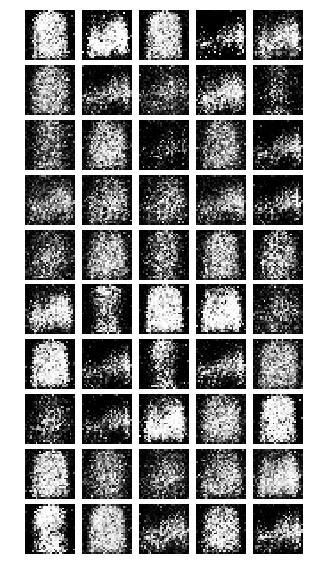

step: 200, D_loss: 0.367518, D_accuracy: 87.50%, G_loss: 2.269054


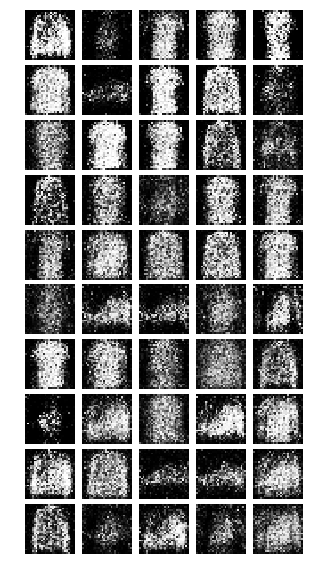

step: 300, D_loss: 0.398747, D_accuracy: 84.38%, G_loss: 1.803391


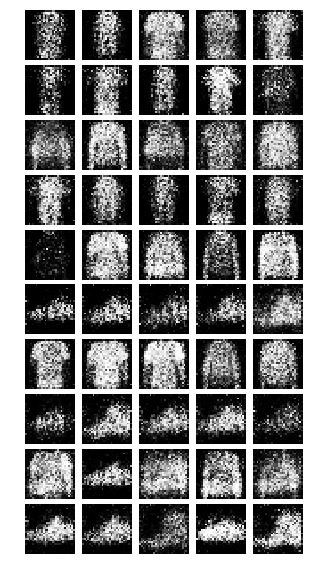

step: 400, D_loss: 0.546918, D_accuracy: 68.75%, G_loss: 1.133268


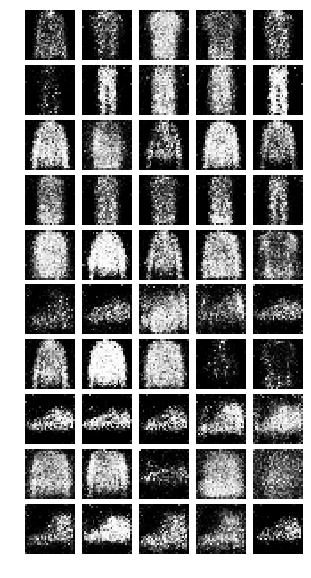

step: 500, D_loss: 0.621015, D_accuracy: 60.94%, G_loss: 1.063289


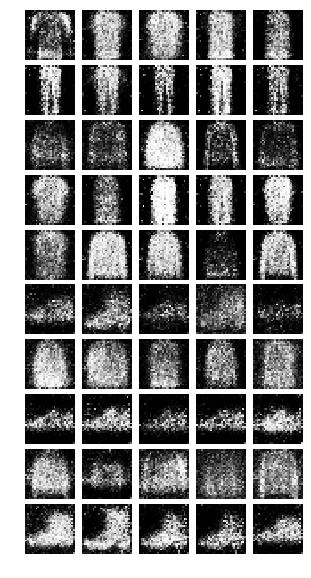

step: 600, D_loss: 0.572559, D_accuracy: 68.75%, G_loss: 1.019488


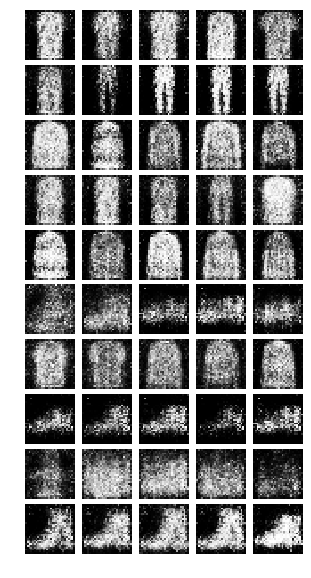

step: 700, D_loss: 0.527595, D_accuracy: 71.88%, G_loss: 1.268431


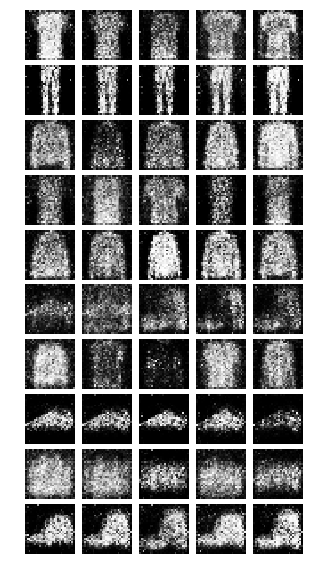

step: 800, D_loss: 0.604835, D_accuracy: 60.94%, G_loss: 1.175077


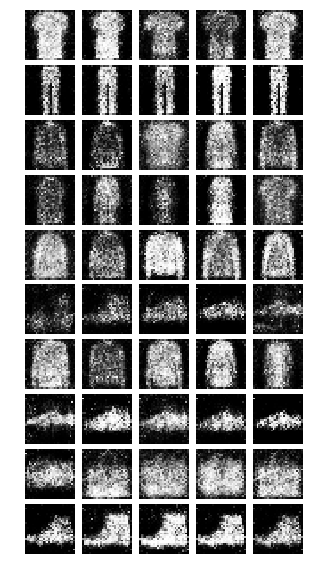

step: 900, D_loss: 0.560394, D_accuracy: 73.44%, G_loss: 1.390205


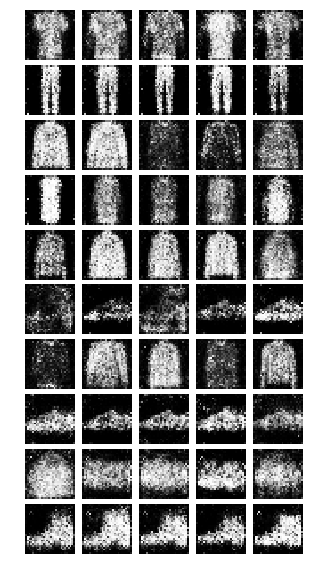

step: 1000, D_loss: 0.650340, D_accuracy: 62.50%, G_loss: 1.109978


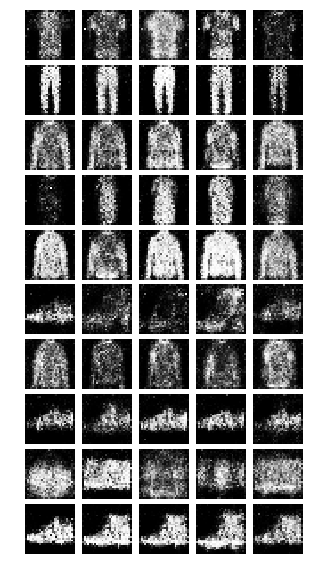

step: 1100, D_loss: 0.687759, D_accuracy: 62.50%, G_loss: 1.175101


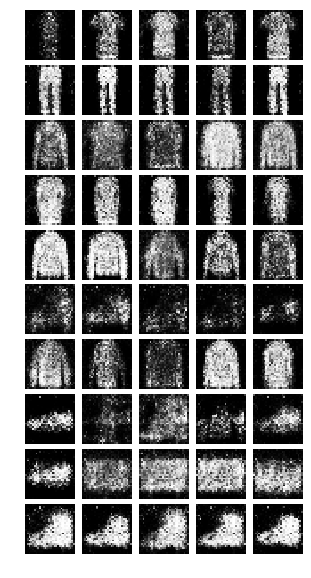

step: 1200, D_loss: 0.609274, D_accuracy: 65.62%, G_loss: 1.087598


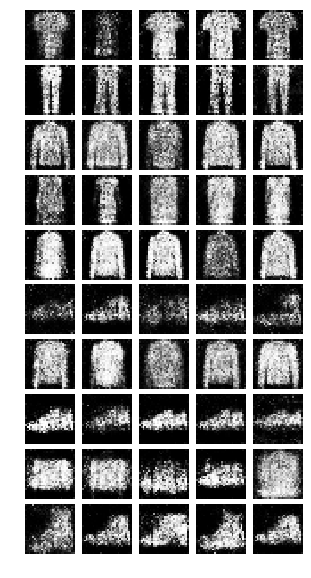

step: 1300, D_loss: 0.572022, D_accuracy: 73.44%, G_loss: 1.258401


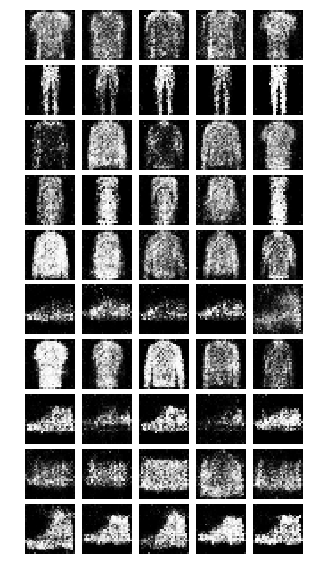

step: 1400, D_loss: 0.640544, D_accuracy: 56.25%, G_loss: 1.161270


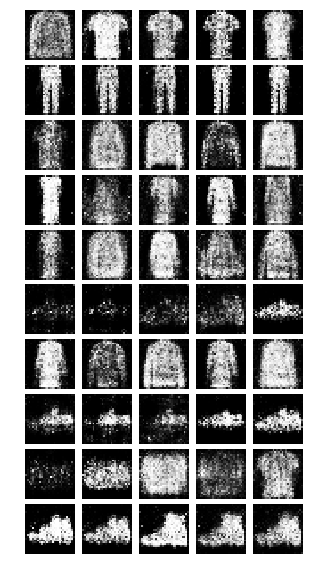

step: 1500, D_loss: 0.610432, D_accuracy: 67.19%, G_loss: 1.195740


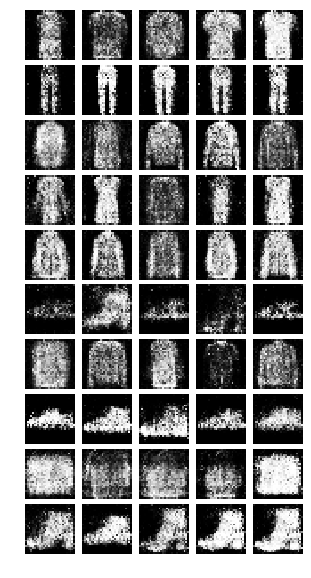

step: 1600, D_loss: 0.548377, D_accuracy: 70.31%, G_loss: 1.136171


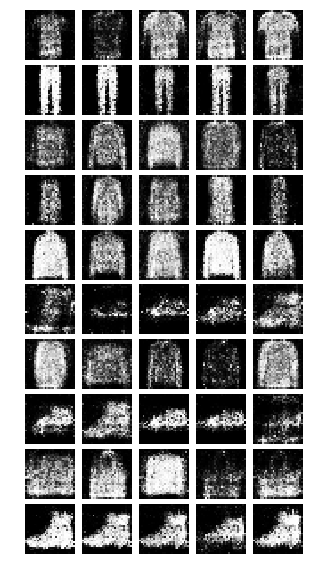

step: 1700, D_loss: 0.582615, D_accuracy: 67.19%, G_loss: 1.059073


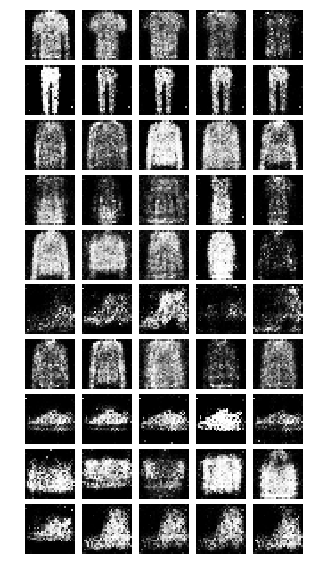

step: 1800, D_loss: 0.609527, D_accuracy: 65.62%, G_loss: 1.104477


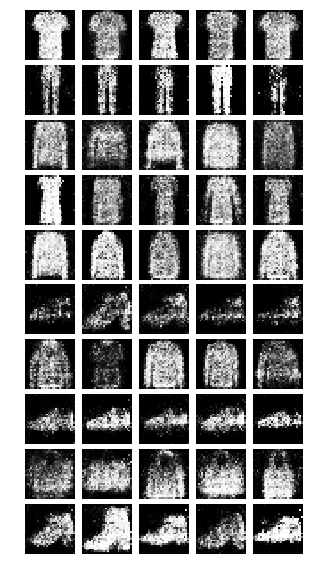

step: 1900, D_loss: 0.652532, D_accuracy: 60.94%, G_loss: 1.151232


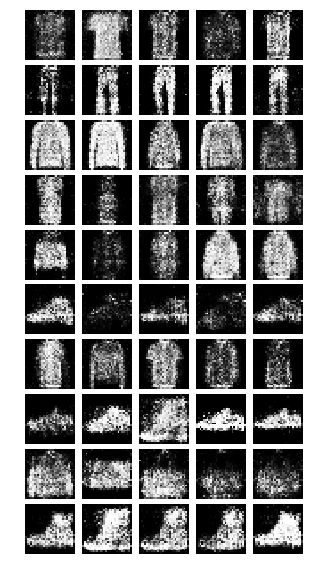

step: 2000, D_loss: 0.593008, D_accuracy: 75.00%, G_loss: 1.257772


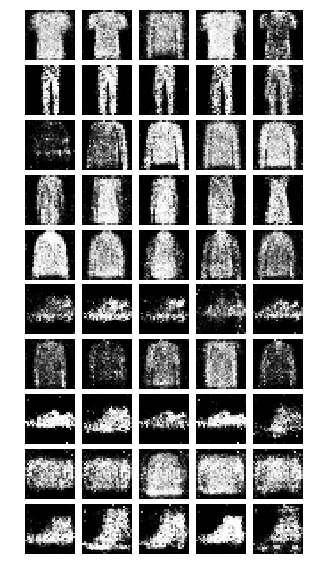

step: 2100, D_loss: 0.629002, D_accuracy: 67.19%, G_loss: 1.076187


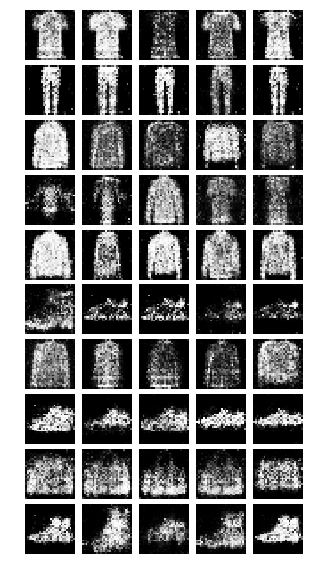

step: 2200, D_loss: 0.525078, D_accuracy: 75.00%, G_loss: 1.127194


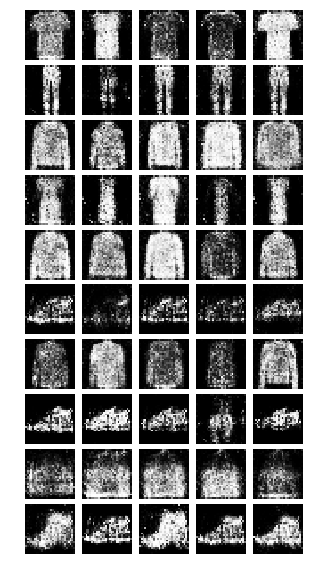

step: 2300, D_loss: 0.571246, D_accuracy: 75.00%, G_loss: 1.135196


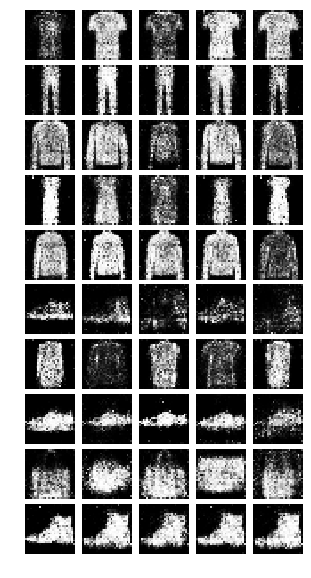

step: 2400, D_loss: 0.630197, D_accuracy: 67.19%, G_loss: 1.108307


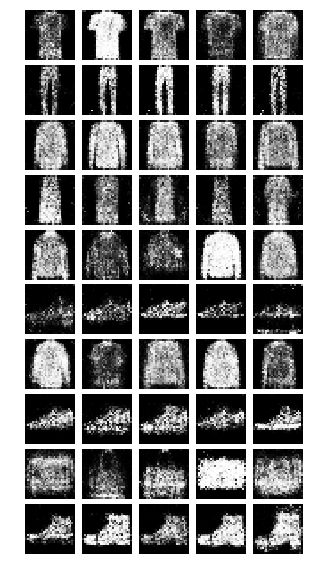

step: 2500, D_loss: 0.756459, D_accuracy: 50.00%, G_loss: 1.039911


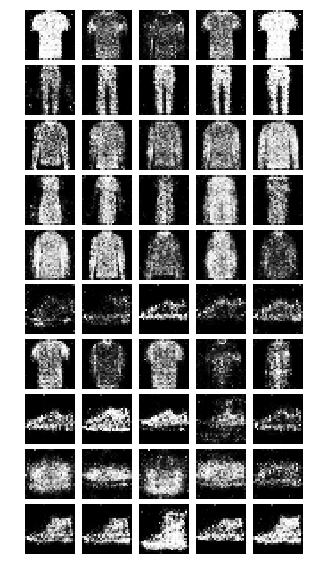

step: 2600, D_loss: 0.705626, D_accuracy: 59.38%, G_loss: 1.115738


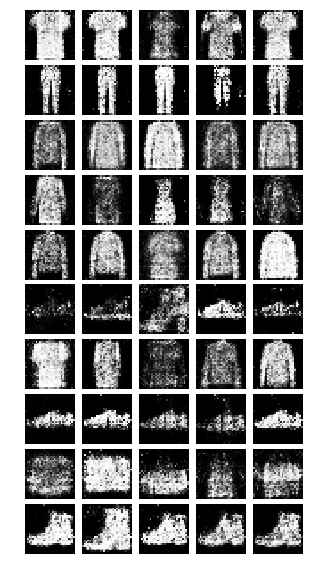

step: 2700, D_loss: 0.650269, D_accuracy: 62.50%, G_loss: 1.129890


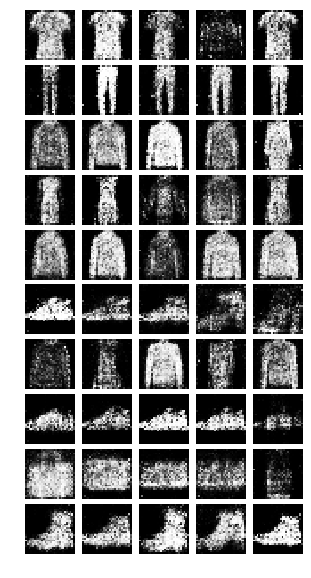

step: 2800, D_loss: 0.620438, D_accuracy: 65.62%, G_loss: 1.085822


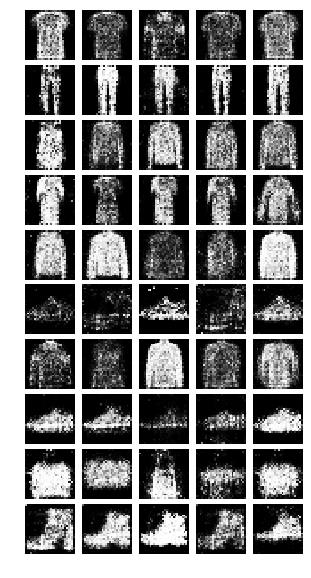

step: 2900, D_loss: 0.599400, D_accuracy: 68.75%, G_loss: 1.115826


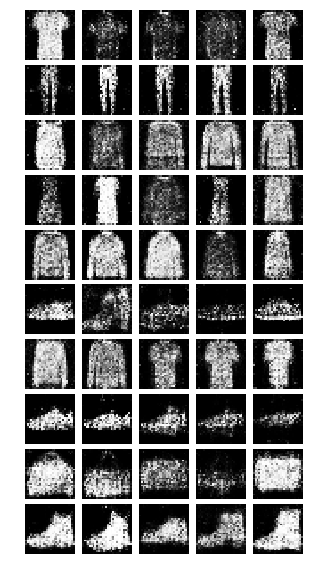

step: 3000, D_loss: 0.646244, D_accuracy: 64.06%, G_loss: 1.221609


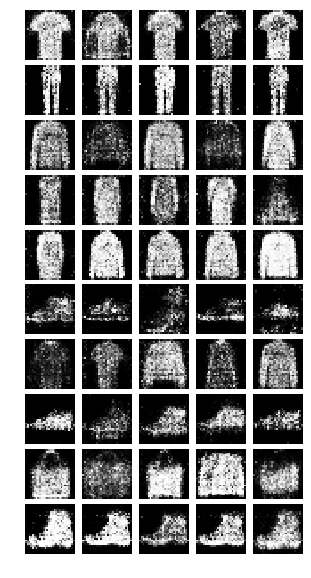

step: 3100, D_loss: 0.506513, D_accuracy: 81.25%, G_loss: 1.086603


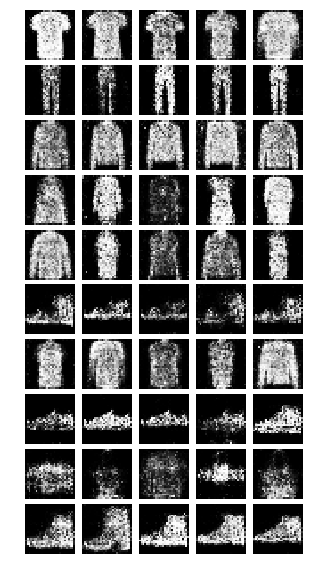

step: 3200, D_loss: 0.544513, D_accuracy: 75.00%, G_loss: 1.071505


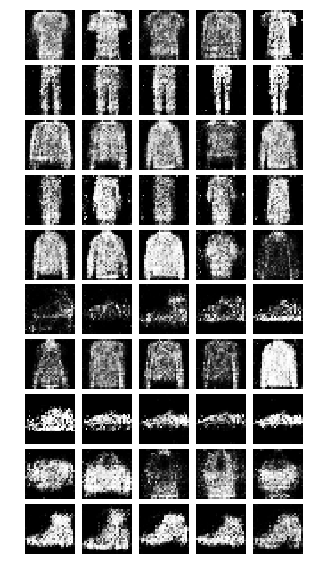

step: 3300, D_loss: 0.642657, D_accuracy: 60.94%, G_loss: 1.176941


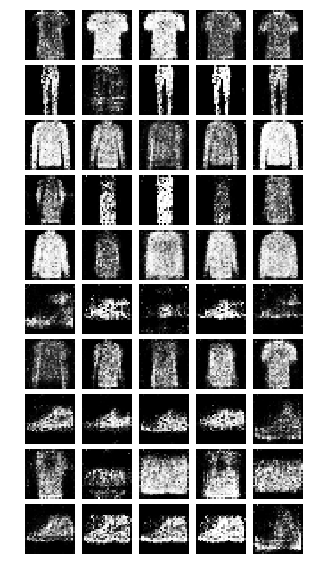

step: 3400, D_loss: 0.640485, D_accuracy: 60.94%, G_loss: 1.246628


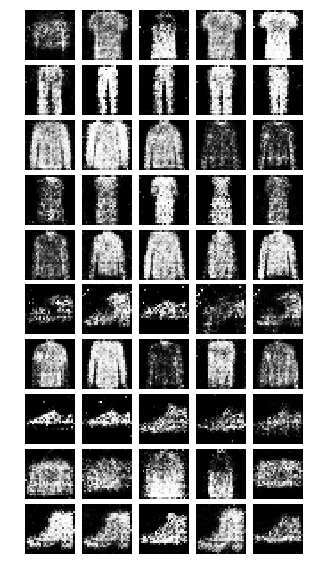

step: 3500, D_loss: 0.674060, D_accuracy: 57.81%, G_loss: 1.087948


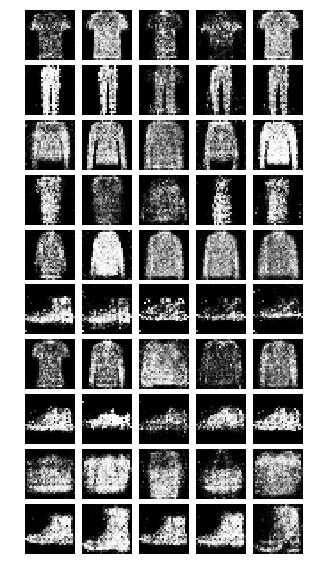

step: 3600, D_loss: 0.617021, D_accuracy: 73.44%, G_loss: 1.115777


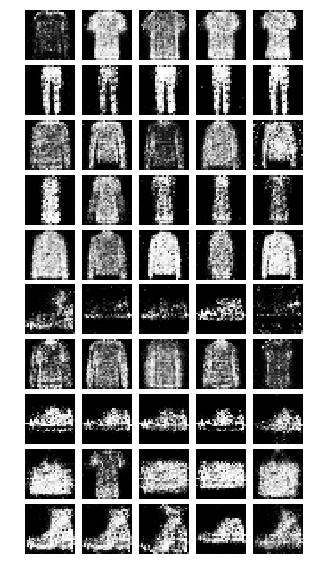

step: 3700, D_loss: 0.669346, D_accuracy: 53.12%, G_loss: 1.113167


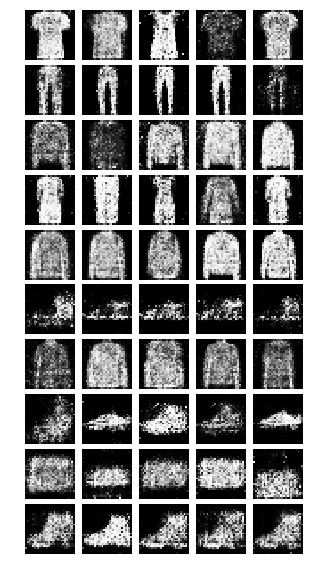

step: 3800, D_loss: 0.620496, D_accuracy: 57.81%, G_loss: 1.115924


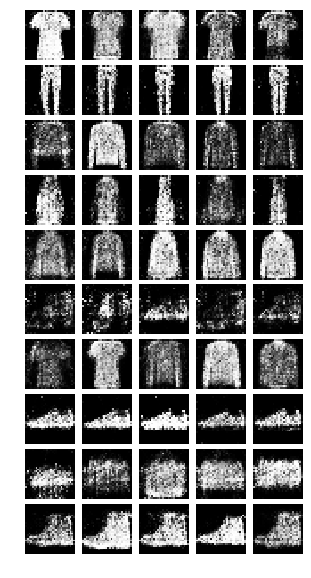

step: 3900, D_loss: 0.537775, D_accuracy: 79.69%, G_loss: 1.130986


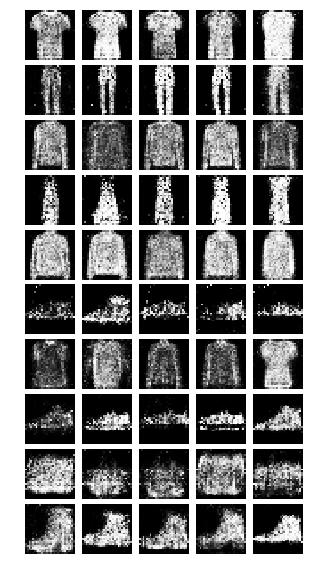

step: 4000, D_loss: 0.713709, D_accuracy: 42.19%, G_loss: 1.086548


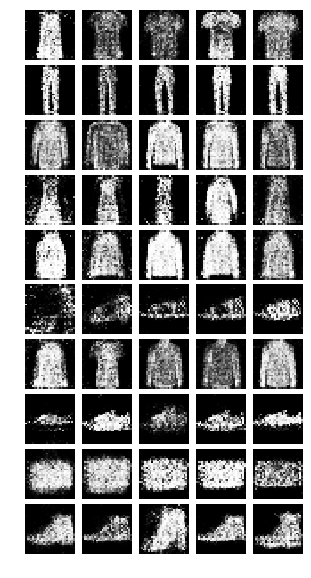

step: 4100, D_loss: 0.596416, D_accuracy: 70.31%, G_loss: 1.150556


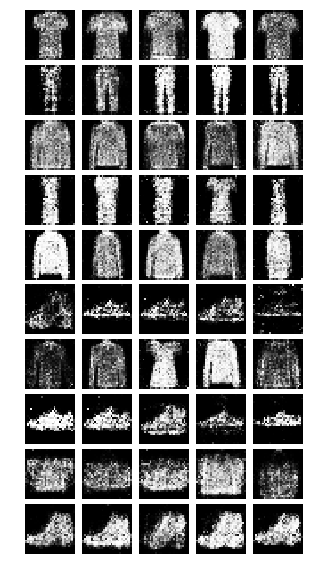

step: 4200, D_loss: 0.637486, D_accuracy: 60.94%, G_loss: 1.074908


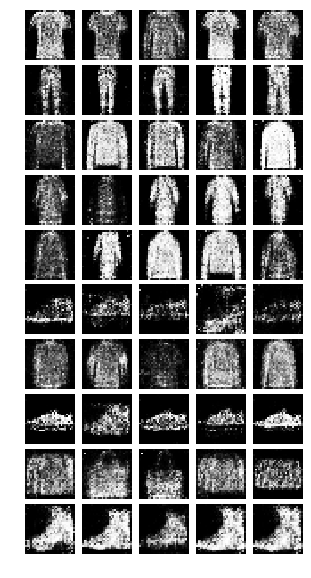

step: 4300, D_loss: 0.627100, D_accuracy: 62.50%, G_loss: 1.120496


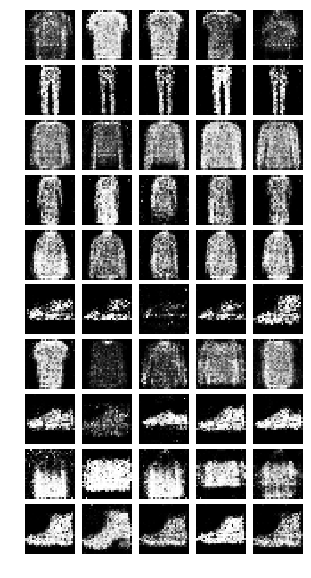

step: 4400, D_loss: 0.587952, D_accuracy: 75.00%, G_loss: 1.014262


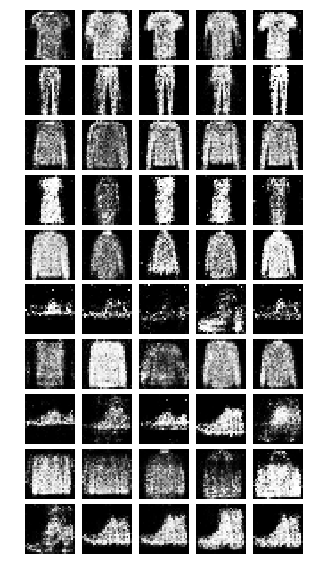

step: 4500, D_loss: 0.701256, D_accuracy: 59.38%, G_loss: 1.132532


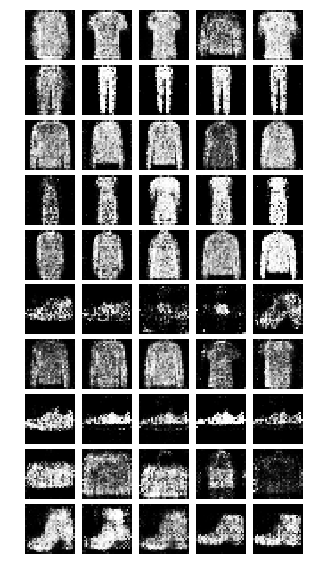

step: 4600, D_loss: 0.613340, D_accuracy: 67.19%, G_loss: 1.117956


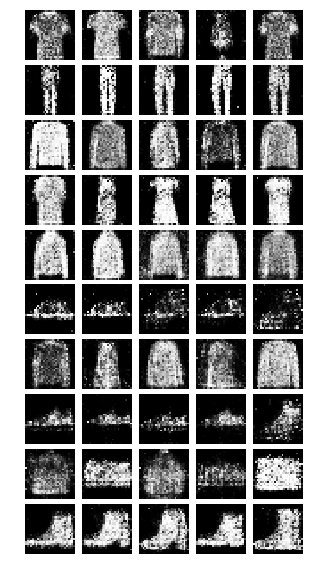

step: 4700, D_loss: 0.644328, D_accuracy: 60.94%, G_loss: 0.988136


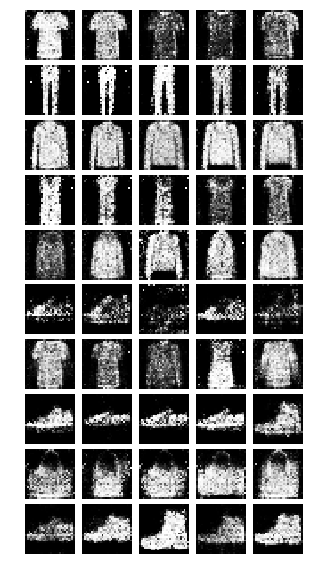

step: 4800, D_loss: 0.513300, D_accuracy: 81.25%, G_loss: 1.179542


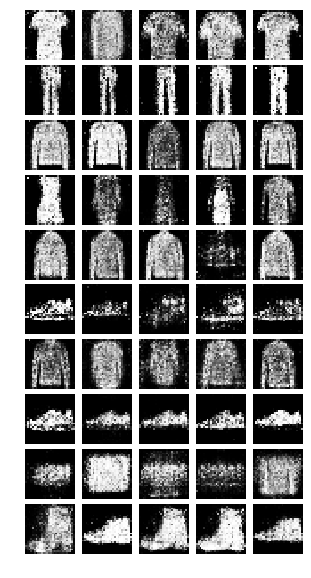

step: 4900, D_loss: 0.642002, D_accuracy: 70.31%, G_loss: 1.106703


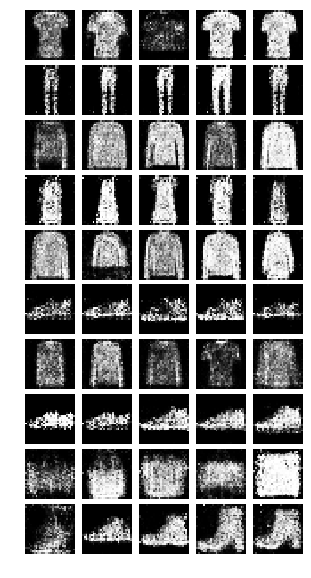

step: 5000, D_loss: 0.655417, D_accuracy: 67.19%, G_loss: 1.060737


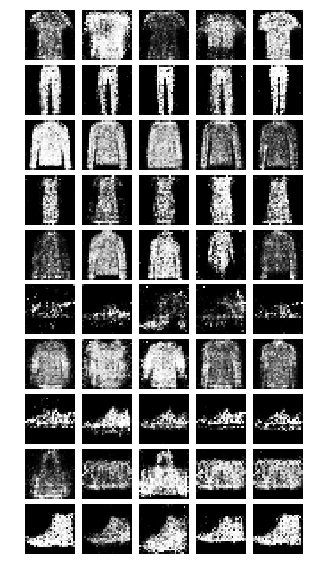

In [0]:
%rm -r /content/images
%mkdir /content/images
train(compiled_models, noise_size, img_shape, batch_size, steps)

### Display samples

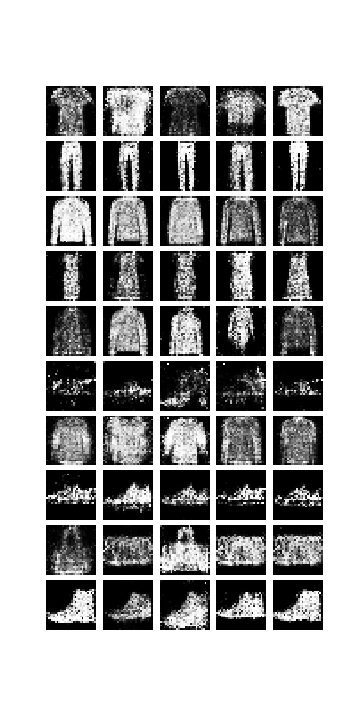

In [0]:
Image('/content/images/%d.png' % 5000)